<a href="https://colab.research.google.com/github/Douglasepol/fake_news_detection/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de Fake News


Vivemos na era digital, onde a informação está mais acessível do que nunca, e continua ficando cada vez mais acessível, de forma mais ágil e ampla.

Apesar dos benefícios que isso traz, também existem problemas e riscos com isso. Aqui, vamos nos preocupar com um dos maiores deles: ***Fake News***
<p align=center>
  <img src="https://image.freepik.com/free-photo/woman-reading-newspaper_53876-13446.jpg" height="30%">
</p>

Com certeza você já se deparou com uma dessas. Em uma era de informação, a desinformação acaba sendo o nosso maior problema.

Em suma, ***Fake News*** são, como a tradução literal sugere, Notícias Falsas. Elas podem ir desde um número diferente em uma estatística apresentada, até a notícia de uma acontecimento completamente falso.



## Como isso influencia nossa vida?

Como de costume, nós tendemos a acreditar nos grandes veículos de mídia, ou de pessoas do nosso ciclo de amigos que nos encaminham notícias em redes sociais. Dessa forma, criamos o hábito de não checar nossas fontes, e assim, acreditamos e disseminamos notícias falsas, às vezes sem nem saber.

Isso se torna um grande problema quando afeta o resultado de algo importante no bem comum de nossa sociedade, como resultados de eleições, opinião pública sobre determinados projetos, políticas públicas, e até pessoas públicas, sejam elas do meio político, artístico, jornalístico, ou qualquer outro.

## O Projeto

Hoje em dia, podemos contar com ferramentas que nos ajudem a identificar e filtrar notícias falsas. Com técnicas de *Machine Learning* essa tarefa de vasculhar diversas fontes de notícias para descobrir o que é falso e o que é factual fica mais fácil.

> O objetivo do projeto é treinar um modelo que seja capaz de classificar notícias, com a melhor acurácia possível, entre falsas ou factuais.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importando os pacotes necessarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import os

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# configurando o noteebook
np.random.seed(42)
sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')


import nltk # NLP
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
import re 

from wordcloud import WordCloud


In [ ]:
# carregando e verificando os dados
data_fake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection/data/Fake.csv')
data_true = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection/data/True.csv')

data_fake['target'] = 1
data_true['target'] = 0
df = pd.concat([data_true, data_fake], ignore_index=True, sort=False)
print(df.isna().sum())

title      0
text       0
subject    0
date       0
target     0
dtype: int64


In [ ]:
df.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


### Os Dados
Nosso conjunto de dados possui quase 45 mil linhas e 5 colunas, das quais temos:

* `title` - Título da notícia
* `text` - Texto da notícia
* `subject` - Assunto da notícia
* `date` - Data em que foi publicada
* `Target` que é nossa variável alvo e está dividida em:
  * True (Factual) = 0
  * Fake (Falsa) = 1


## Visualização dos dados

Nessa etapa veremos como estão distribuidas as amostras em relação ao tipo de artigo ('subject').


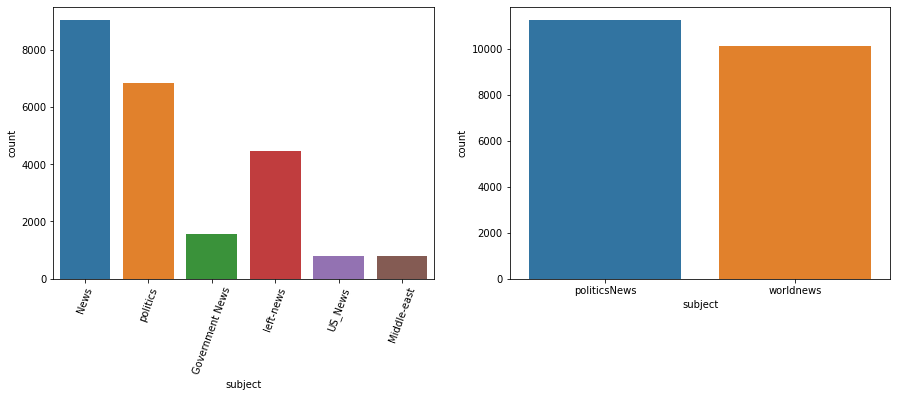

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot('subject', data=data_fake)
plt.xticks(rotation =70)

plt.subplot(1, 2, 2)
sns.countplot('subject', data=data_true)
plt.show()

### Nuvem de Palavras

As *Word Clouds* (Nuvens de Palavras) são representações visuais que dão maior destaque às palavras que aparecem com mais frequência.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

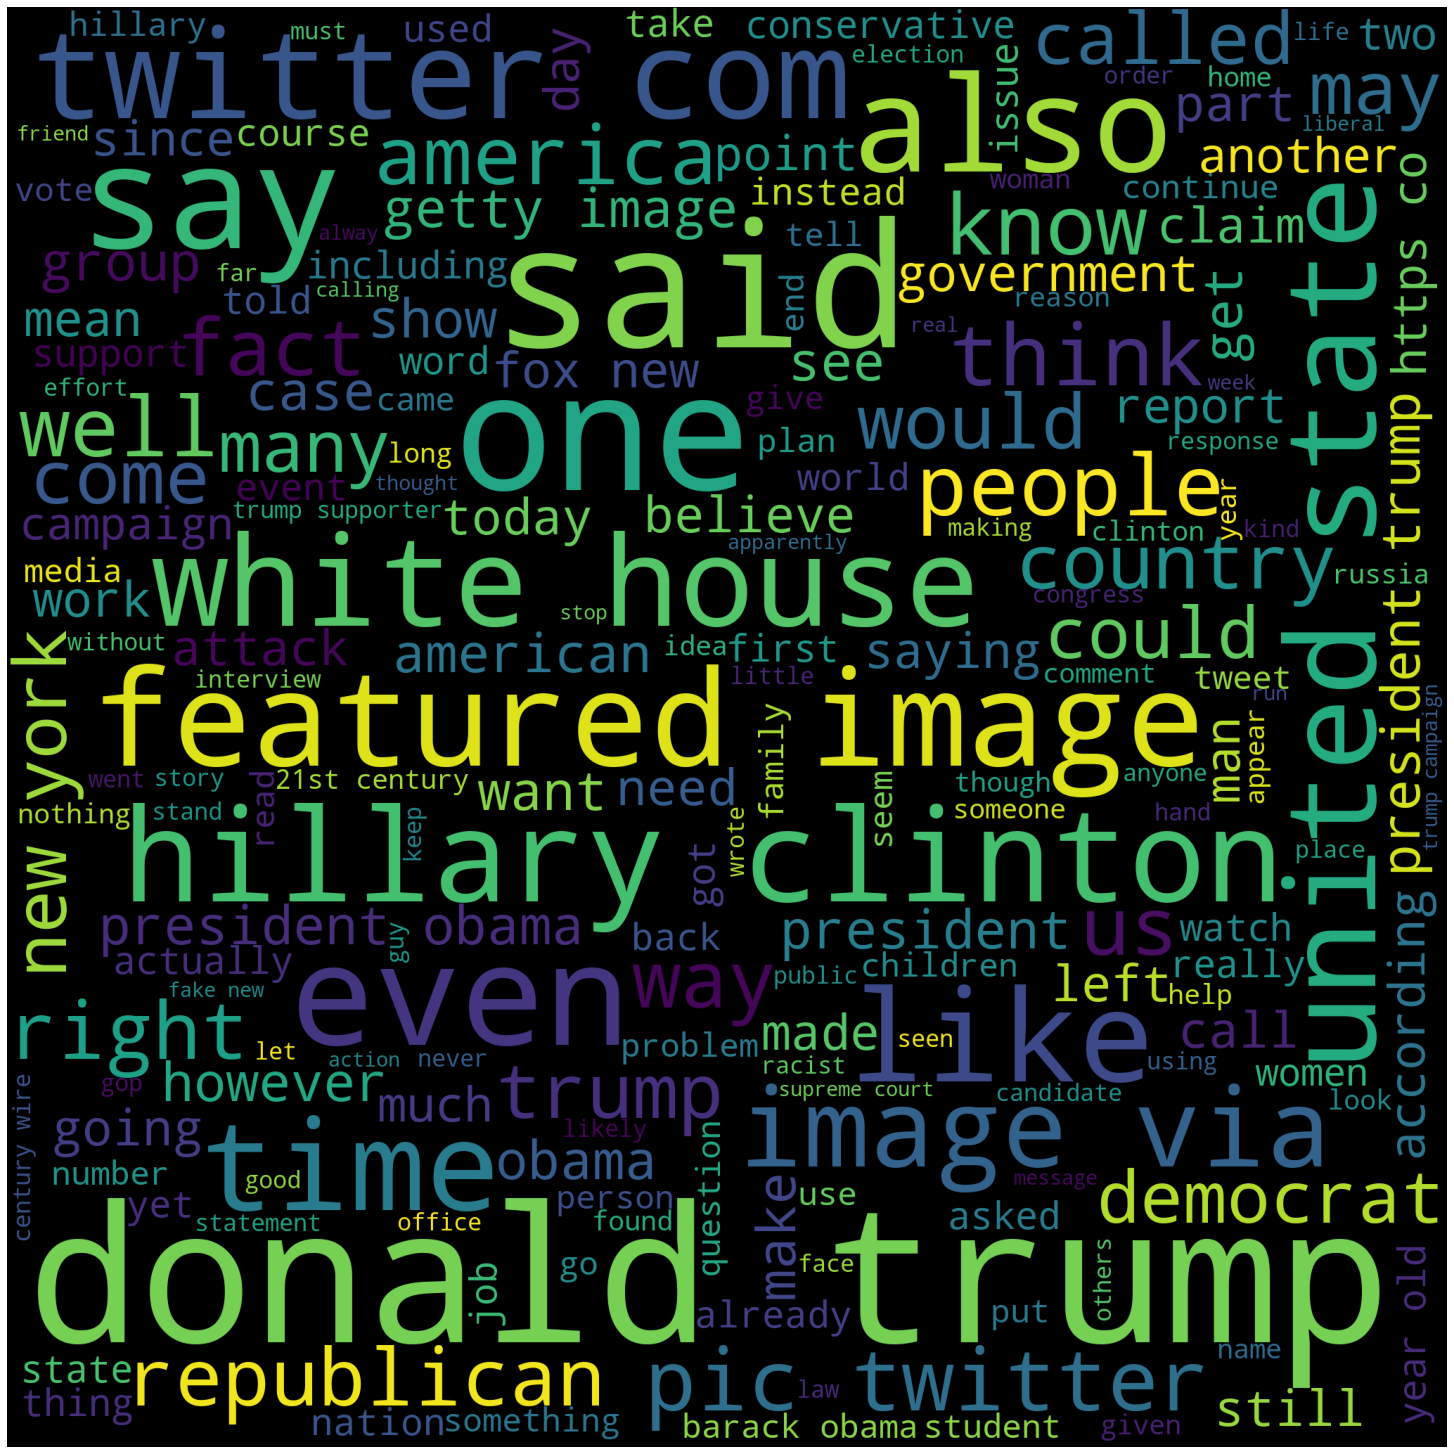

In [ ]:
# Word_Cloud
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

comment_words = '' 
stopwords = set(stop_words) 
  
for val in df[df['target']==1]['text']: 

    val = str(val) 
    tokens = val.split() 

    # converter cada token em lowercase
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 2048, height = 2048, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Tratando os Dados

Aqui, estamos lidando com nossa linguagem natural em formato de `string`, então precisamos de alguns conhecimentos de NLP para tratar esses dados da melhor forma, para que possam ser passados ao nosso modelo com sucesso, e dessa forma, obtermos os resultados que desejamos.

In [ ]:
# tratando texto das notícias
import string
def clean_text(text):
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    return words

df['text'] = df['text'].apply(clean_text)
df.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters the head of a conse...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,washington reuters transgender people wi...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters the special counsel ...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign advise...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,seattlewashington reuters president donal...,politicsNews,"December 29, 2017",0


Agora, o que precisamos é separar nossos dados em treino, validação e teste, para que possamos continuar a trilhar o caminho que nos leva ao modelo.

In [ ]:
# separando os datasets em treino, validação e teste
train, test = train_test_split(df)
train, validation = train_test_split(train, test_size = 0.2)
print('Entradas por Dataset')
print('Dataset de Treino: ',len(train), 'linhas.')
print('Dataset de Validação: ', len(validation), 'linhas.')
print('Dataset de Teste: ', len(test), 'linhas.')

Entradas por Dataset
Dataset de Treino:  26938 linhas.
Dataset de Validação:  6735 linhas.
Dataset de Teste:  11225 linhas.


### Pré-Processamento de Strings - NLP

Aqui neste projeto estamos focando em ***Deep Learning*** e a implementação de **Redes Neurais**, por isso, não iremos nos extender em pré-processamento de Strings.

De qualquer forma, esse é um ponto importante do projeto. Aqui, basicamente o que queremos é simplificar o texto, para que seja mais fácil do nosso modelo processar e entender. Por isso, iremos utilizar uma técnica que se chama ***Tokenizing***.

Em suma, Tokenizing, ou Tokenização, em tradução livre, é um passo que separa longos textos de strings em pedaços de textos mais curtos, chamados de tokens.

<p align=center>
  <img src="https://www.kdnuggets.com/wp-content/uploads/text-tokens-tokenization-manning.jpg" height="30%">
</p>

Para ler mais sobre esse assunto e entender melhor os passos e parâmetros abaixo, deixarei links de referência [aqui](https://www.kdnuggets.com/2017/12/general-approach-preprocessing-text-data.html) e [aqui](https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html).

In [ ]:
# preparando os dados para o modelo
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train.text)
word_index = tokenizer.word_index

# aplicando técnicas tokenizing e padding
training_sequences = tokenizer.texts_to_sequences(np.array(train.text))
training_padded = pad_sequences(training_sequences,truncating=trunc_type, padding=pad_type)

max_length = len(training_padded[0])

validation_sequences = tokenizer.texts_to_sequences(np.array(validation.text))
validation_padded = pad_sequences(validation_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

# criando arrays com inputs
x_train = np.copy(training_padded)
x_val = np.copy(validation_padded)
y_train = train['target'].values
y_val = validation['target'].values

In [ ]:
# verificando o tamanho dos arrays
print('Tamanho dos Arrays')
print('Treino: ', len(x_train), 'linhas.')
print('Resposta: ', len(y_train), 'linhas.')

Tamanho dos Arrays
Treino:  26938 linhas.
Resposta:  26938 linhas.


### Preparando, Instanciando e Treinando o Modelo

In [ ]:
# instanciando e dando fit no modelo
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, (155), input_length=max_length),
        tf.keras.layers.Conv1D(16, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), 
                      metrics=['accuracy'])
history = model.fit(x_train, y_train, verbose = 2, epochs = 3, validation_data = (x_val, y_val),
                   callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=6)])

Epoch 1/3
842/842 - 1260s - loss: 0.0784 - accuracy: 0.9736 - val_loss: 0.0097 - val_accuracy: 0.9981 - 1260s/epoch - 1s/step
Epoch 2/3
842/842 - 1250s - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0064 - val_accuracy: 0.9987 - 1250s/epoch - 1s/step
Epoch 3/3
842/842 - 1249s - loss: 8.1706e-04 - accuracy: 0.9999 - val_loss: 0.0051 - val_accuracy: 0.9991 - 1249s/epoch - 1s/step


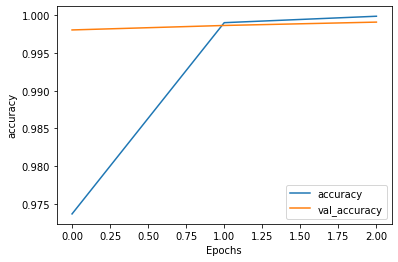

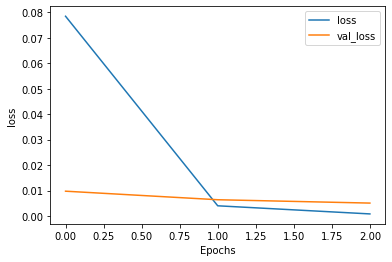

In [ ]:
# visualizando os resultados
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Fazendo Previsões no Conjunto de Teste

Por fim, temos o pipeline ideal para tratar nossos dados, já treinamos, tunamos e obtivemos excelentes resultados em nosso conjunto de validação. Nosso modelo está pronto, mas ele tem mais uma missão a cumprir. 

Vamos apresentar dados completamente novos a ele, fazer previsõs e ver como ele se sai.

In [ ]:
# tratando os dados de teste
test_sequences = tokenizer.texts_to_sequences(np.array(test.text))
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

In [ ]:
# fazendo previsões
preds = np.round(model.predict(test_padded))

In [ ]:
# conferindo o tamanho do resultado
len(preds)

11225

In [ ]:
# verificando a acurácia
acc = np.sum(1 if i==j else 0 for i,j in zip(preds, test["target"].values)) / len(test)
print("Accuracy: ", acc )

Accuracy:  0.9981291759465479


# Modelo LSTM

In [ ]:
# train_test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.3, random_state=0)

In [ ]:
# tokenize
max_features = 10000 # 100 * 100
maxlen = 256 # avg maxlen 225

token = Tokenizer(num_words=max_features)
token.fit_on_texts(X_train)

# tokenize train 
tokenized_train = token.texts_to_sequences(X_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

# tokenize test
tokenized_test = token.texts_to_sequences(X_test)
x_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
model = Sequential()
model.add(Embedding(max_features, output_dim=100, input_length=maxlen, trainable=False))

model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 256, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:.4f}.hdf5'
Checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=256, 
                    validation_split=0.2, 
                    verbose=1, 
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping_callback, Checkpointer])

Epoch 1/10
99/99 [==============================] - ETA: 0s - loss: 0.5091 - accuracy: 0.7452
Epoch 1: val_loss improved from inf to 0.35231, saving model to ./model/01-0.3523.hdf5
99/99 [==============================] - 406s 4s/step - loss: 0.5091 - accuracy: 0.7452 - val_loss: 0.3523 - val_accuracy: 0.8554
Epoch 2/10
99/99 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.8413
Epoch 2: val_loss did not improve from 0.35231
99/99 [==============================] - 410s 4s/step - loss: 0.3725 - accuracy: 0.8413 - val_loss: 0.3800 - val_accuracy: 0.8557
Epoch 3/10
99/99 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.8659
Epoch 3: val_loss improved from 0.35231 to 0.25499, saving model to ./model/03-0.2550.hdf5
99/99 [==============================] - 405s 4s/step - loss: 0.3230 - accuracy: 0.8659 - val_loss: 0.2550 - val_accuracy: 0.9001
Epoch 4/10
99/99 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8812
Epoch 4: 

In [ ]:
print('Accuracy: {:.4f}'.format(model.evaluate(x_test, y_test)[1]))

421/421 [==============================] - 56s 132ms/step - loss: 0.6917 - accuracy: 0.5248
Accuracy: 0.5248
